In [117]:
import numpy as np

Vin = 12
Li = 1.2e-03
Lo = 3.6e-03
Ci = 11.57e-06
Co = 3.86e-06
fsw = 30000
D = 0.75
R = 129.6
Duty_inicial = 0.75
Vref = 36

# Parâmetros
L1 = 1.2e-3
L2 = 3.6e-3
C1 = 11.57e-6
C2 = 3.86e-6
R = 129.6

# Funções para construir matrizes variáveis
def build_A(D):
    return np.array([
    [0,
     0,
     -(1-D)/Li,
     -(1-D)/Li],

    [0,
     0,
     D/Lo,
     -(1-D)/Lo],

    [(1-D)/Ci,
     -D/Ci,
     0,
     0],

    [(1-D)/Co,
     (1-D)/Co,
     0,
     -1/(R*Co)]
])

A = build_A(Duty_inicial)

B = np.array([
    [1 / Li],
    [0],
    [0],
    [0]
])
    
C = np.array([
    [0, 0, 0, 1]])

D_sys = np.zeros((1, 1))  # 1 saída, 1 entrada


In [124]:
import numpy as np
import random
import pandas as pd
from scipy.optimize import minimize

# ---------- Funções auxiliares ----------
#Gera um numero aleatorio entre a e b
def gerar_valor_aleatorio(a, b):
    return random.uniform(a, b)

#Gera uma função que retorna valores em degraus, mudando nos tempos definidos.
def gerar_funcao_variavel(tempos, valores, valor_padrao):
    def func(i, N):
        t = i / N
        for k in range(len(tempos)):
            if t < tempos[k]:
                return valores[k-1] if k > 0 else valor_padrao
        return valores[-1]
    return func

def gerar_variaveis_aleatorias():
    qtd_var_Vin = random.randint(1, 4)  # até 4 mudanças de Vin
    qtd_var_Vref = random.randint(1, 3) # até 3 mudanças de Vref

    
    tempos_Vin = sorted([gerar_valor_aleatorio(0, 1) for _ in range(qtd_var_Vin)])
    valores_Vin = [gerar_valor_aleatorio(12, 20) for _ in range(qtd_var_Vin)]

    tempos_Vref = sorted([gerar_valor_aleatorio(0, 1) for _ in range(qtd_var_Vref)])
    valores_Vref = [gerar_valor_aleatorio(20, 40) for _ in range(qtd_var_Vref)]

    return tempos_Vin, valores_Vin, tempos_Vref, valores_Vref

# ---------- Sua simulação MPC ----------
#Método Runge-Kutta de 4º ordem
def rk4_step(f, x, u, dt):
    k1 = f(x, u)
    k2 = f(x + dt/2 * k1, u)
    k3 = f(x + dt/2 * k2, u)
    k4 = f(x + dt * k3, u)
    return x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

def simulate_rk4_ch2(build_A, B, C, D, u_array, x0, dt, t_final, Vref_array, prediction_steps):
    N = int(t_final / dt)
    t = np.linspace(0, t_final, N + 1)

    x = np.zeros((N + 1, len(x0)))
    y = np.zeros((N + 1, C.shape[0]))
    error_abs = np.zeros(N + 1)
    D_array = np.zeros(N + 1)

    lambda_penalty = 4*150.0
    x[0] = x0
    D_array[0] = 0.5

    for i in range(1, N + 1):
        Vref = Vref_array[i]
        x_prev = x[i-1]
        u = u_array[i]
        prev_Duty = D_array[i-1]

        #Função custo, o MPC busca minimizar ela
        def cost_fn_multi(Dvec):
            D0, D1, D2, D3 = Dvec
            D0, D1, D2, D3 = [np.clip(d, 0.3, 0.9) for d in [D0, D1, D2, D3]]

            D_seq = [D0, D1, D2, D3] + [D3] * (prediction_steps - 4)
            x_temp = x_prev.copy()
            error_sum = 0
            for step in range(prediction_steps):
                A = build_A(D_seq[step])
                def f(x_, u_): return A @ x_ + B.flatten() * u_
                x_temp = rk4_step(f, x_temp, u, dt)
                y_pred = C @ x_temp + D.flatten() * u
                error_sum += (abs(y_pred[0] - Vref) / Vref)**2 #Cálculo do erro

            #Penalidade por variação no duty cycle
            penalty = lambda_penalty * (
                (D0 - prev_Duty)**2 +
                (D1 - D0)**2 +
                (D2 - D1)**2 +
                (D3 - D2)**2
            )
            return error_sum + penalty

        res = minimize(cost_fn_multi,
                       x0=[prev_Duty, prev_Duty, prev_Duty, prev_Duty],
                       bounds=[(0.3, 0.9)]*4,
                       method='L-BFGS-B')

        best_D0 = res.x[0]
        A_best = build_A(best_D0)
        def f_best(x_, u_): return A_best @ x_ + B.flatten() * u_
        best_x = rk4_step(f_best, x_prev, u, dt)
        best_y = C @ best_x + D.flatten() * u

        x[i] = best_x
        y[i] = best_y
        error_abs[i] = cost_fn_multi(res.x)
        D_array[i] = best_D0

    return t, x, y, error_abs, D_array

# ---------- Rodar várias simulações e salvar dataset ----------
def rodar_simulacoes(build_A, B, C, D_sys, num_simulacoes=5, salvar_dataset=True):
    import matplotlib.pyplot as plt

    dt = 50e-6
    t_final = 8e-3
    N = int(t_final / dt) + 1
    t = np.linspace(0, t_final, N)

    dataset = []
    for sim in range(num_simulacoes):
        print(f"\n=== Simulação {sim+1} ===")

        # Gerar variações aleatórias
        tempos_Vin, valores_Vin, tempos_Vref, valores_Vref = gerar_variaveis_aleatorias()

        print("Mudanças de Vin:")
        for tt, vv in zip(tempos_Vin, valores_Vin):
            print(f"t = {tt*t_final*1000:.3f} ms -> Vin = {vv:.2f} V")

        print("Mudanças de Vref:")
        for tt, vv in zip(tempos_Vref, valores_Vref):
            print(f"t = {tt*t_final*1000:.3f} ms -> Vref = {vv:.2f} V")

        # Criar funções
        Vin_func = gerar_funcao_variavel(tempos_Vin, valores_Vin, valores_Vin[0])
        Vref_func = gerar_funcao_variavel(tempos_Vref, valores_Vref, valores_Vref[0])

        # Gerar sinais discretos
        u_array = np.array([Vin_func(i, N) for i in range(N)])
        Vref_array = np.array([Vref_func(i, N) for i in range(N)])

        # Rodar simulação MPC
        x0 = [0, 0, 0, 0]
        t_out, x, y, error_abs, D_array = simulate_rk4_ch2(
            build_A, B, C, D_sys, u_array, x0, dt, t_final, Vref_array, prediction_steps=15
        )

        # Guardar dados no dataset
        linha = np.stack([y[:,0], u_array, Vref_array, D_array], axis=1)  # [Vout, Vin, Vref, Duty]
        dataset.append(linha)

        # === PLOTAR RESULTADOS ===
        '''
        t_ms = t_out * 1000
        plt.figure(figsize=(12, 8))

        plt.subplot(4, 1, 1)
        plt.plot(t_ms, u_array, label="Vin")
        plt.ylabel("Vin [V]")
        plt.grid(True)

        plt.subplot(4, 1, 2)
        plt.plot(t_ms, Vref_array, 'r--', label="Vref")
        plt.ylabel("Vref [V]")
        plt.grid(True)

        plt.subplot(4, 1, 3)
        plt.plot(t_ms, D_array, label="Duty")
        plt.ylabel("Duty")
        plt.grid(True)

        plt.subplot(4, 1, 4)
        plt.plot(t_ms, y[:,0], label="Vout")
        plt.plot(t_ms, Vref_array, 'r--', alpha=0.7, label="Vref")
        plt.ylabel("Vout [V]")
        plt.xlabel("Tempo [ms]")
        plt.legend()
        plt.grid(True)

        plt.suptitle(f"Simulação {sim+1}")
        plt.tight_layout()
        plt.show()
        '''

    dataset = np.array(dataset)

    if salvar_dataset:
        import pandas as pd
        n = dataset.shape[1]
        colunas = ['Vout', 'Vin', 'Vref', 'Duty']
        colunas_expand = [f"{c}_{i}" for i in range(n) for c in colunas]
        df = pd.DataFrame(dataset.reshape(num_simulacoes, -1), columns=colunas_expand)
        df.to_csv("dataset_mpc.csv", index=False)
        print("\nDataset salvo como dataset_mpc.csv")

    return dataset


In [4]:
dataset = rodar_simulacoes(build_A, B, C, D_sys, num_simulacoes=10000, salvar_dataset=True)



=== Simulação 1 ===
Mudanças de Vin:
t = 3.188 ms -> Vin = 18.14 V
t = 6.130 ms -> Vin = 14.96 V
Mudanças de Vref:
t = 3.790 ms -> Vref = 39.50 V

=== Simulação 2 ===
Mudanças de Vin:
t = 3.890 ms -> Vin = 15.74 V
Mudanças de Vref:
t = 1.166 ms -> Vref = 38.21 V
t = 5.501 ms -> Vref = 37.77 V

=== Simulação 3 ===
Mudanças de Vin:
t = 0.560 ms -> Vin = 19.91 V
t = 1.106 ms -> Vin = 14.96 V
t = 4.826 ms -> Vin = 16.77 V
t = 7.654 ms -> Vin = 14.68 V
Mudanças de Vref:
t = 1.055 ms -> Vref = 27.82 V
t = 3.197 ms -> Vref = 37.32 V
t = 3.577 ms -> Vref = 30.19 V

=== Simulação 4 ===
Mudanças de Vin:
t = 0.633 ms -> Vin = 15.99 V
t = 5.222 ms -> Vin = 18.17 V
Mudanças de Vref:
t = 3.789 ms -> Vref = 38.78 V
t = 5.683 ms -> Vref = 30.25 V
t = 6.459 ms -> Vref = 34.28 V

=== Simulação 5 ===
Mudanças de Vin:
t = 0.200 ms -> Vin = 15.69 V
t = 3.788 ms -> Vin = 13.73 V
t = 7.957 ms -> Vin = 16.78 V
Mudanças de Vref:
t = 5.269 ms -> Vref = 32.50 V
t = 7.096 ms -> Vref = 31.11 V

=== Simulação 6 ==

In [165]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# =========================
# 1) Carregar dataset salvo
# =========================
df = pd.read_csv("dataset_mpc.csv")

# Número de simulações e pontos
n_cols = len(df.columns)
n_points = n_cols // 4   # pq temos [Vout, Vin, Vref, Duty]
num_sim = len(df)


X_list, y_list = [], []

dt = 50e-6  # passo de tempo

for sim in range(num_sim):
    Vout = df.iloc[sim].filter(like="Vout").values
    Vin = df.iloc[sim].filter(like="Vin").values
    Vref = df.iloc[sim].filter(like="Vref").values
    Duty = df.iloc[sim].filter(like="Duty").values

    erro = Vref - Vout
    integral_erro = np.cumsum(erro) * dt
    integral_erro = np.clip(integral_erro, -17, 17)

    # começar em k=4, pois vamos acessar até k-3
    for k in range(4, n_points):
        e_k = erro[k]
        e_prev = erro[k-1]
        e_prev2 = erro[k-2]
        e_prev3 = erro[k-3]
        d_prev = Duty[k-1]
        d_prev2 = Duty[k-2]
        d_prev3 = Duty[k-3]
        int_e = integral_erro[k]

        # entrada com os novos erros passados
        X_list.append([e_k, e_prev, e_prev2, e_prev3, d_prev, d_prev2, d_prev3, int_e])
        y_list.append(Duty[k])

X = np.array(X_list)
y = np.array(y_list)

print("Dataset montado:", X.shape, y.shape)

# =========================
# 2) Pré-processamento
# =========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalizar saída duty (0.3 a 0.9)
y_scaled = (y - 0.3) / (0.9 - 0.3)

# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled,
                                                    test_size=0.2, shuffle=True)

# =========================
# 3) Definir e treinar MLP
# =========================
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(8,)),   # 8 entradas
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),        # 30% de dropout
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse',
              metrics=['mae'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=12,
                    batch_size=128,
                    verbose=1)

# =========================
# 4) Avaliar
# =========================
loss, mae = model.evaluate(X_test, y_test)
print(f"\nLoss={loss:.6f}, MAE={mae:.6f}")

# Converter saída de volta para duty real
def predict_duty(features):
    f_scaled = scaler.transform([features])
    d_norm = model.predict(f_scaled)[0,0]
    duty = d_norm * (0.9 - 0.3) + 0.3
    return duty

# =========================
# 5) Exportar para TFLite
# =========================

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("mpc_mlp.tflite", "wb") as f:
    f.write(tflite_model)

print("\nModelo salvo como mpc_mlp.tflite")


Dataset montado: (1570000, 8) (1570000,)
Epoch 1/12
9813/9813 ━━━━━━━━━━━━━━━━━━━━ 6s 519us/step - loss: 6.9546e-04 - mae: 0.0146 - val_loss: 5.8648e-04 - val_mae: 0.0194
Epoch 2/12
9813/9813 ━━━━━━━━━━━━━━━━━━━━ 5s 508us/step - loss: 4.5252e-05 - mae: 0.0046 - val_loss: 4.8623e-04 - val_mae: 0.0178
Epoch 3/12
9813/9813 ━━━━━━━━━━━━━━━━━━━━ 5s 499us/step - loss: 3.3893e-05 - mae: 0.0040 - val_loss: 4.6790e-04 - val_mae: 0.0172
Epoch 4/12
9813/9813 ━━━━━━━━━━━━━━━━━━━━ 5s 502us/step - loss: 3.0206e-05 - mae: 0.0037 - val_loss: 4.0486e-04 - val_mae: 0.0163
Epoch 5/12
9813/9813 ━━━━━━━━━━━━━━━━━━━━ 5s 501us/step - loss: 2.8287e-05 - mae: 0.0036 - val_loss: 4.1746e-04 - val_mae: 0.0164
Epoch 6/12
9813/9813 ━━━━━━━━━━━━━━━━━━━━ 5s 488us/step - loss: 2.8069e-05 - mae: 0.0036 - val_loss: 4.2767e-04 - val_mae: 0.0164
Epoch 7/12
9813/9813 ━━━━━━━━━━━━━━━━━━━━ 5s 478us/step - loss: 2.7150e-05 - mae: 0.0035 - val_loss: 4.0614e-04 - val_mae: 0.0163
Epoch 8/12
9813/9813 ━━━━━━━━━━━━━━━━━━━━ 5s 500u

INFO:tensorflow:Assets written to: C:\Users\YGORDE~1\AppData\Local\Temp\tmpo2cgyxj6\assets


Saved artifact at 'C:\Users\YGORDE~1\AppData\Local\Temp\tmpo2cgyxj6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8), dtype=tf.float32, name='keras_tensor_84')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2545595734272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2545595742192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2545595732864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2545595736208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2545595735856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2545595728992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2545595729520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2544854537088: TensorSpec(shape=(), dtype=tf.resource, name=None)

Modelo salvo como mpc_mlp.tflite


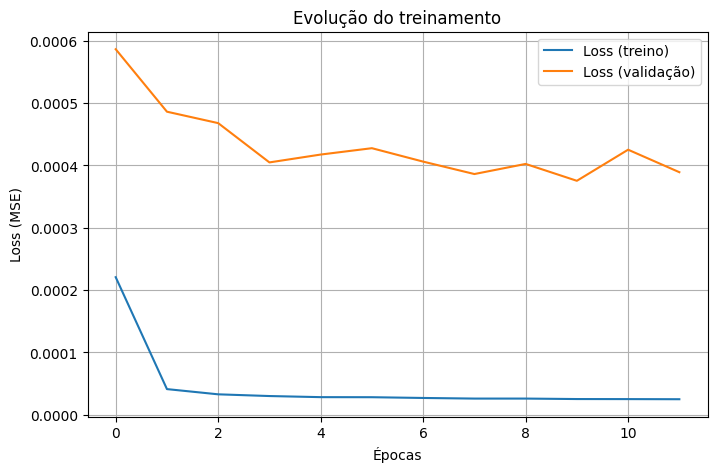

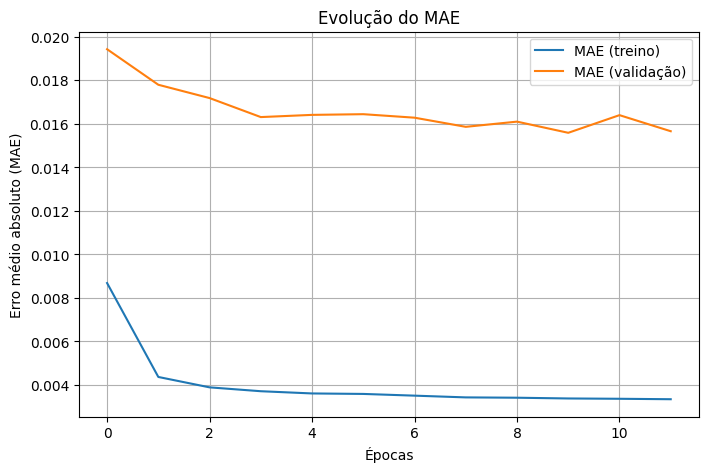

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Loss (treino)')
plt.plot(history.history['val_loss'], label='Loss (validação)')
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.title("Evolução do treinamento")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='MAE (treino)')
plt.plot(history.history['val_mae'], label='MAE (validação)')
plt.xlabel("Épocas")
plt.ylabel("Erro médio absoluto (MAE)")
plt.title("Evolução do MAE")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━

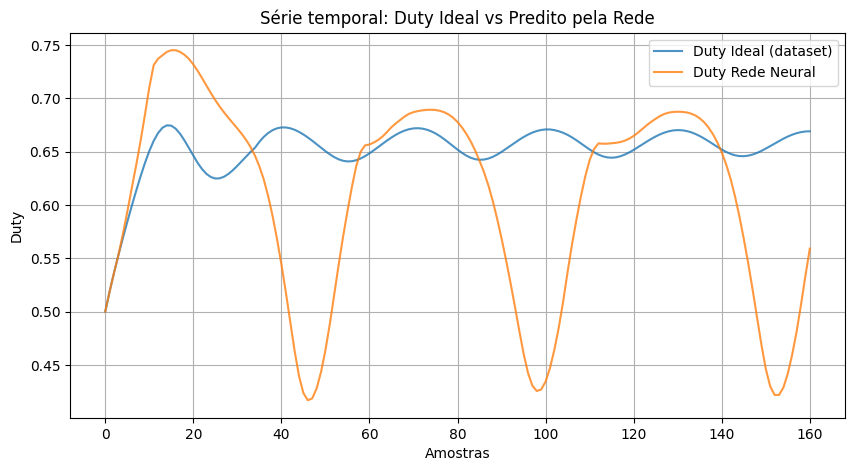

In [99]:
import matplotlib.pyplot as plt

# =========================
# Testar em uma simulação específica
# =========================
sim = 30  # índice da simulação para visualizar
Vout = df.iloc[sim].filter(like="Vout").values
Vin   = df.iloc[sim].filter(like="Vin").values
Vref  = df.iloc[sim].filter(like="Vref").values
Duty  = df.iloc[sim].filter(like="Duty").values

erro = Vref - Vout
integral_erro = np.cumsum(erro) * dt
integral_erro = np.clip(integral_erro, -10, 10)

# precisamos de pelo menos 4 valores iniciais (para e_{k-3})
duty_pred = [Duty[0], Duty[1], Duty[2], Duty[3]]  # seed inicial

# reconstruir série predita
for k in range(4, len(Vout)):
    e_k = erro[k]
    e_prev = erro[k-1]
    e_prev2 = erro[k-2]
    e_prev3 = erro[k-3]
    d_prev = duty_pred[-1]  # último valor calculado
    d_prev2 = duty_pred[-2]
    d_prev3 = duty_pred[-3]
    int_e = integral_erro[k]

    feat = [e_k, e_prev, e_prev2, e_prev3, d_prev, d_prev2, d_prev3, int_e]
    d_k = predict_duty(feat)  # usa a rede
    duty_pred.append(d_k)

# Plot comparando a série temporal
plt.figure(figsize=(10,5))
plt.plot(Duty, label="Duty Ideal (dataset)", alpha=0.8)
plt.plot(duty_pred, label="Duty Rede Neural", alpha=0.8)
plt.xlabel("Amostras")
plt.ylabel("Duty")
plt.title("Série temporal: Duty Ideal vs Predito pela Rede")
plt.legend()
plt.grid(True)
plt.show()


In [83]:
import tensorflow as tf
import numpy as np

# Carregar o modelo TFLite
interpreter = tf.lite.Interpreter(model_path="mpc_mlp.tflite")
interpreter.allocate_tensors()

# Pegar índices de entrada e saída
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_duty_tflite(features, scaler):
    f_scaled = scaler.transform([features]).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], f_scaled)
    interpreter.invoke()
    d_norm = interpreter.get_tensor(output_details[0]['index'])[0,0]

    duty = d_norm * (0.9 - 0.3) + 0.3
    return duty


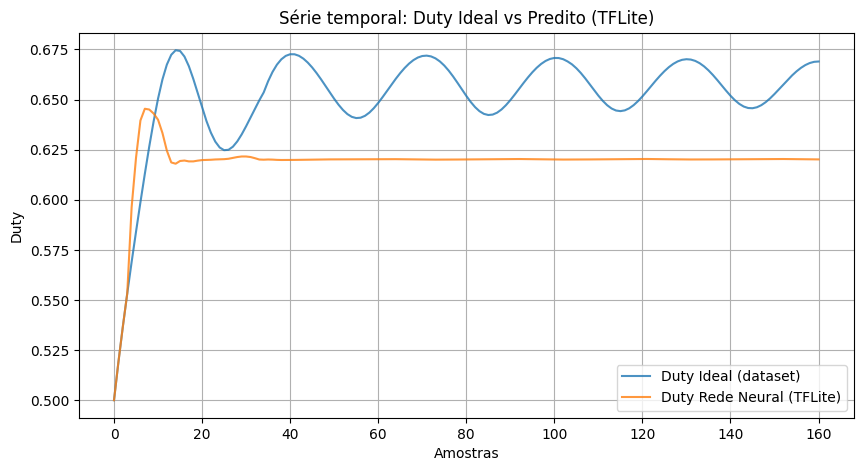

In [88]:
# Escolhe uma simulação do dataset
sim = 30
Vout = df.iloc[sim].filter(like="Vout").values
Vin   = df.iloc[sim].filter(like="Vin").values
Vref  = df.iloc[sim].filter(like="Vref").values
Duty  = df.iloc[sim].filter(like="Duty").values

erro = Vref - Vout
integral_erro = np.cumsum(erro) * dt
integral_erro = np.clip(integral_erro, -10, 10)

# =========================
# Reconstruir série com TFLite
# =========================
duty_pred_tflite = [Duty[0], Duty[1], Duty[2], Duty[3]]  # 4 valores iniciais

for k in range(4, len(Vout)):
    e_k = erro[k]
    e_prev = erro[k-1]
    e_prev2 = erro[k-2]
    e_prev3 = erro[k-3]
    d_prev = duty_pred_tflite[-1]
    d_prev2 = duty_pred_tflite[-2]
    d_prev3 = duty_pred_tflite[-3]

    '''
    Observe a diferença que há quando ele usa o duty anterior que ele previu e o controlador previu
    A forma que qualquer pequeno erro causa grandes oscilações na ideia do duty que ele previu
    Mas em tese eu tmb teria que mandar o erro novo dele né? 
    d_prev = Duty[k-1]
    d_prev2 = Duty[k-2]
    d_prev3 = Duty[k-3]
    '''
    int_e = integral_erro[k]

    feat = [e_k, e_prev, e_prev2, e_prev3, d_prev, d_prev2, d_prev3, int_e]
    d_k = predict_duty_tflite(feat, scaler)
    duty_pred_tflite.append(d_k)

# =========================
# Plotar comparação
# =========================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(Duty, label="Duty Ideal (dataset)", alpha=0.8)
plt.plot(duty_pred_tflite, label="Duty Rede Neural (TFLite)", alpha=0.8)
plt.xlabel("Amostras")
plt.ylabel("Duty")
plt.title("Série temporal: Duty Ideal vs Predito (TFLite)")
plt.legend()
plt.grid(True)
plt.show()


Formato do DataFrame: (10000, 644)
Tamanho de cada vetor: 161


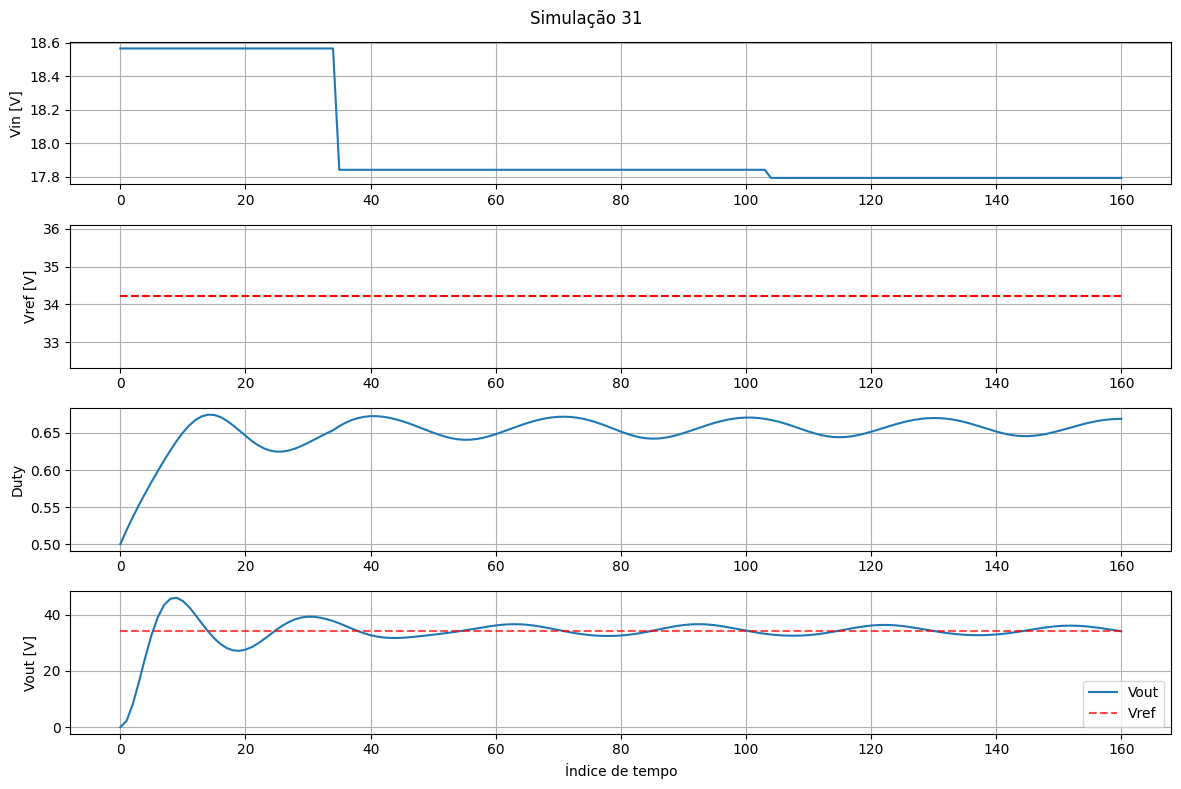

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o CSV
df = pd.read_csv("dataset_mpc.csv")

print("Formato do DataFrame:", df.shape)

# Pegar a primeira simulação (linha 0)
sim_idx = 30
Vout = df.iloc[sim_idx].filter(like="Vout").values
Vin   = df.iloc[sim_idx].filter(like="Vin").values
Vref  = df.iloc[sim_idx].filter(like="Vref").values
Duty  = df.iloc[sim_idx].filter(like="Duty").values

print("Tamanho de cada vetor:", len(Vout))

# Plotar pra conferir
plt.figure(figsize=(12,8))

plt.subplot(4,1,1)
plt.plot(Vin, label="Vin")
plt.ylabel("Vin [V]")
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(Vref, "r--", label="Vref")
plt.ylabel("Vref [V]")
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(Duty, label="Duty")
plt.ylabel("Duty")
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(Vout, label="Vout")
plt.plot(Vref, "r--", alpha=0.7, label="Vref")
plt.ylabel("Vout [V]")
plt.xlabel("Índice de tempo")
plt.legend()
plt.grid(True)

plt.suptitle(f"Simulação {sim_idx+1}")
plt.tight_layout()
plt.show()


# LSTM

In [115]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# =========================
# 1) Carregar dataset salvo
# =========================
df = pd.read_csv("dataset_mpc.csv")

n_cols = len(df.columns)
n_points = n_cols // 4
num_sim = len(df)

dt = 50e-6
seq_len = 5  # número de passos que a LSTM vai ver

X_list, y_list = [], []

for sim in range(num_sim):
    Vout = df.iloc[sim].filter(like="Vout").values
    Vin = df.iloc[sim].filter(like="Vin").values
    Vref = df.iloc[sim].filter(like="Vref").values
    Duty = df.iloc[sim].filter(like="Duty").values

    erro = Vref - Vout
    integral_erro = np.cumsum(erro) * dt
    integral_erro = np.clip(integral_erro, -17, 17)

    # criar sequências para LSTM
    for k in range(seq_len, n_points):
        seq = []
        for s in range(seq_len):
            seq.append([erro[k-s], integral_erro[k-s], Duty[k-s]])  # features por passo
        X_list.append(seq[::-1])  # seq[::-1] para manter ordem temporal correta
        y_list.append(Duty[k])

X = np.array(X_list)  # shape: [num_samples, seq_len, features]
y = np.array(y_list)  # shape: [num_samples]

print("Dataset montado:", X.shape, y.shape)

# =========================
# 2) Pré-processamento
# =========================
# Normalizar features
X_reshaped = X.reshape(-1, 3)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)

# Normalizar saída duty
y_scaled = (y - 0.3) / (0.9 - 0.3)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, shuffle=True
)

# =========================
# 3) Definir e treinar LSTM
# =========================
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_len, 3)),
    tf.keras.layers.LSTM(64, activation='tanh', return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # saída duty normalizado
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse',
              metrics=['mae'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=5,
                    batch_size=64,
                    verbose=1)

# =========================
# 4) Avaliar
# =========================
loss, mae = model.evaluate(X_test, y_test)
print(f"\nLoss={loss:.6f}, MAE={mae:.6f}")

# Função de predição
def predict_duty_lstm(seq_features):
    seq_scaled = scaler_X.transform(seq_features.reshape(-1,3)).reshape(1, seq_len, 3)
    d_norm = model.predict(seq_scaled, verbose=0)[0,0]
    return d_norm * (0.9 - 0.3) + 0.3

# =========================
# 5) Exportar para TFLite
# =========================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# permitir ops do TensorFlow que não são nativas do TFLite
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,     # ops padrão do TFLite
    tf.lite.OpsSet.SELECT_TF_OPS        # ops do TensorFlow selecionadas
]
# evitar lowering problemático de tensor list ops
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

with open("mpc_lstm.tflite", "wb") as f:
    f.write(tflite_model)

print("\nModelo LSTM salvo como mpc_lstm.tflite")


Dataset montado: (1560000, 5, 3) (1560000,)
Epoch 1/5
19500/19500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 2.0362e-04 - mae: 0.0082 - val_loss: 3.9223e-04 - val_mae: 0.0166
Epoch 2/5
19500/19500 ━━━━━━━━━━━━━━━━━━━━ 19s 970us/step - loss: 2.7635e-05 - mae: 0.0038 - val_loss: 3.5054e-04 - val_mae: 0.0164
Epoch 3/5
19500/19500 ━━━━━━━━━━━━━━━━━━━━ 19s 969us/step - loss: 2.2212e-05 - mae: 0.0034 - val_loss: 3.0202e-04 - val_mae: 0.0152
Epoch 4/5
19500/19500 ━━━━━━━━━━━━━━━━━━━━ 19s 960us/step - loss: 1.8760e-05 - mae: 0.0031 - val_loss: 3.5284e-04 - val_mae: 0.0167
Epoch 5/5
19500/19500 ━━━━━━━━━━━━━━━━━━━━ 19s 952us/step - loss: 1.7457e-05 - mae: 0.0030 - val_loss: 3.0266e-04 - val_mae: 0.0156
9750/9750 ━━━━━━━━━━━━━━━━━━━━ 4s 399us/step - loss: 3.0321e-04 - mae: 0.0156

Loss=0.000303, MAE=0.015593
INFO:tensorflow:Assets written to: C:\Users\YGORDE~1\AppData\Local\Temp\tmpxkl2v8fw\assets


INFO:tensorflow:Assets written to: C:\Users\YGORDE~1\AppData\Local\Temp\tmpxkl2v8fw\assets


Saved artifact at 'C:\Users\YGORDE~1\AppData\Local\Temp\tmpxkl2v8fw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5, 3), dtype=tf.float32, name='keras_tensor_49')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2542735155696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2540723248064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2542722442064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2543168267616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2542722443296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2542999121664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2542722441536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2543190863264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2542722435552: TensorSpec(shape=(), dtype=tf.resource, name=None)

Modelo LSTM salvo como mpc_lstm.tflite


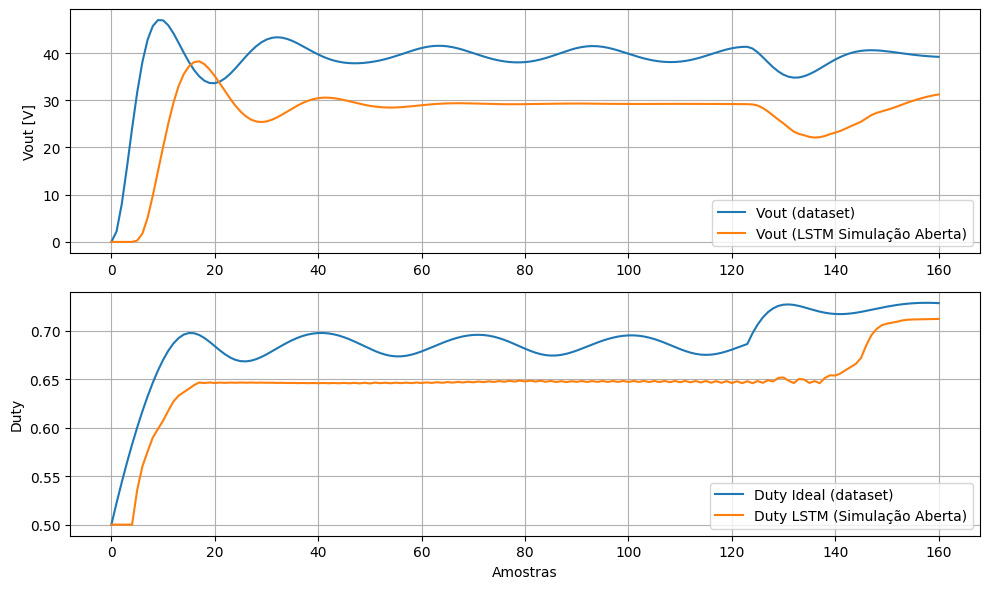

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# ======== Função para prever Duty com LSTM treinada =========
def predict_duty_lstm(seq_features):
    seq_scaled = scaler_X.transform(seq_features.reshape(-1, 3)).reshape(1, seq_len, 3)
    d_norm = model.predict(seq_scaled, verbose=0)[0, 0]
    # Retorna no intervalo original do duty
    return d_norm * (0.9 - 0.3) + 0.3


# ======== Simulação aberta com modelo SEPIC =========
def simulate_open_loop_LSTM(build_A, B, C, D_sys, Vin_array, Vref_array, x0, dt, seq_len=5):
    N = len(Vin_array)
    x = np.zeros((N, len(x0)))
    Vout = np.zeros(N)
    duty_pred = np.zeros(N)
    
    x[0] = x0
    Vout[0] = 0.0
    duty_pred[:seq_len] = 0.5  # duty inicial fixo (pode usar dataset também)
    
    # Inicializa histórico para primeira sequência
    erro_hist = np.zeros(seq_len)
    int_hist = np.zeros(seq_len)
    duty_hist = np.ones(seq_len) * 0.5
    int_erro_acum = 0

    for k in range(seq_len, N):
        # --- Atualizar erro e integral ---
        erro = Vref_array[k-1] - Vout[k-1]
        int_erro_acum += erro * dt
        int_erro_acum = np.clip(int_erro_acum, -17, 17)

        # Atualiza histórico
        erro_hist = np.roll(erro_hist, -1)
        int_hist = np.roll(int_hist, -1)
        duty_hist = np.roll(duty_hist, -1)
        erro_hist[-1] = erro
        int_hist[-1] = int_erro_acum
        duty_hist[-1] = duty_pred[k-1]

        # --- Montar sequência de entrada ---
        seq = np.stack([erro_hist, int_hist, duty_hist], axis=1)
        d_k = predict_duty_lstm(seq)
        d_k = np.clip(d_k, 0.3, 0.9)
        duty_pred[k] = d_k

        # --- Atualizar modelo SEPIC ---
        A = build_A(d_k)
        def f_sep(x_, u_): return A @ x_ + B.flatten() * u_
        x[k] = rk4_step(f_sep, x[k-1], Vin_array[k], dt)
        Vout[k] = (C @ x[k] + D_sys.flatten() * Vin_array[k])[0]

    return Vout, duty_pred


# ======== Execução da simulação =========
sim = 0
Vout_ref = df.iloc[sim].filter(like="Vout").values
Vin_array = df.iloc[sim].filter(like="Vin").values
Vref_array = df.iloc[sim].filter(like="Vref").values

dt = 50e-6
x0 = [0, 0, 0, 0]
Vout_sim, duty_sim = simulate_open_loop_LSTM(build_A, B, C, D_sys, Vin_array, Vref_array, x0, dt, seq_len=5)

# ======== Plotar resultados =========
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(Vout_ref, label="Vout (dataset)")
plt.plot(Vout_sim, label="Vout (LSTM Simulação Aberta)")
plt.ylabel("Vout [V]")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
Duty_ref = df.iloc[sim].filter(like="Duty").values
plt.plot(Duty_ref, label="Duty Ideal (dataset)")
plt.plot(duty_sim, label="Duty LSTM (Simulação Aberta)")
plt.ylabel("Duty")
plt.xlabel("Amostras")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# FAZENDO O TESTE

In [2]:
import tensorflow as tf
import numpy as np
#mpc_mlp_v2.tflite
# Carregar o modelo TFLite
interpreter = tf.lite.Interpreter(model_path="mpc_mlp.tflite")
#interpreter = tf.lite.Interpreter(model_path="mpc_mlp_v2.tflite")
interpreter.allocate_tensors()

# Pegar índices de entrada e saída
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


def predict_duty_tflite(features, scaler):
    f_scaled = scaler.transform([features]).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], f_scaled)
    interpreter.invoke()
    d_norm = interpreter.get_tensor(output_details[0]['index'])[0,0]

    duty = d_norm * (0.9 - 0.3) + 0.3
    return duty



In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ========================================
# 1) Parâmetros do SEPIC
# ========================================
RL1 = 3
RL2 = 8
L1 = 1.56e-3
L2 = 4e-3
C1 = 3.18e-6
Co = 200e-9
R = 129.6
Vin = 12.0

# Duty fixo (você pode trocar depois para variar com o tempo)
Duty = 0.5

# ========================================
# 2) Funções do modelo médio
# ========================================
def build_A(D):
    return np.array([
        [-(RL1 / L1),        0,              -(1 - D) / L1,   0],
        [0,                 -(RL2 / L2),      D / L2,         -1 / L2],
        [(1 - D) / C1,       -D / C1,         0,               0],
        [0,                  1 / Co,          0,              -1 / (R * Co)]
    ])

B = np.array([
    [1 / L1],
    [0],
    [0],
    [0]
])

C = np.array([
    [0, 0, 0, 1],   # Vout
    [1, 0, 0, 0]    # Corrente em L1
])
D_sys = np.zeros((2, 1))

# ========================================
# 3) Função de integração RK4
# ========================================
def rk4_step(f, x, u, dt):
    k1 = f(x, u)
    k2 = f(x + dt/2 * k1, u)
    k3 = f(x + dt/2 * k2, u)
    k4 = f(x + dt * k3, u)
    return x + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

# ========================================
# 4) Simulação temporal
# ========================================
def simulate_sepic_open_loop(Vin, t_final=0.01, dt=50e-6):
    D = 0.5
    A = build_A(D)
    N = int(t_final / dt)
    t = np.linspace(0, t_final, N+1)
    
    
    # Estados: [iL1, iL2, vC1, vCo]
    x = np.zeros((N+1, 4))
    y = np.zeros((N+1, 2))
    error = np.zeros(N+1)
    duty_vector = np.zeros(N+1)
    duty_vector[:5] = 0.5  # inicializa com duty fixo

    x0 = np.zeros(4)
    x[0] = x0
    integral_error =0
    Vref = 36  # apenas para calcular erro
    u = Vin

    A = build_A(duty_vector[1])
    
    for i in range(1, N+1):


        if i > N*0.17 and i < N*0.35 :
          #Vref=30
          Vref = 36

        elif i >= N*0.35 and i<N*0.55:
            #Vref = 24
            Vref = 36

        elif i >= N*0.6:
            #Vref = 30
            Vref = 36


        else:
            #Vref = 20
            Vref =36
        
        def f(x_, u_):
            return A @ x_ + B.flatten() * u_
        
        

        x[i] = rk4_step(f, x[i-1], u, dt)
        y[i] = C @ x[i] + D_sys.flatten() * u
        error[i] = Vref - y[i, 0]  # erro apenas de tensão de saída
        integral_error = error[i] * dt + integral_error
        integral_error = np.clip(integral_error, -17, 17)
        #Calcula novo duty cycle
        if i >= 4:
            e_k = error[i]
            e_prev = error[i-1]
            e_prev2 = error[i-2]
            e_prev3 = error[i-3]
            d_prev = duty_vector[i-1]
            d_prev2 = duty_vector[i-2]
            d_prev3 = duty_vector[i-3]
            int_e = integral_error

            features = np.array([e_k, e_prev, e_prev2, e_prev3,
                                 d_prev, d_prev2, d_prev3, int_e],
                                dtype=float)
            d_k = predict_duty_tflite(features, scaler)
            duty_vector[i]=d_k
            duty_vector[i] = np.clip(d_k, 0.3, 0.9)
            A = build_A(duty_vector[i])

    return t, x, y, error, duty_vector

# ========================================
# 5) Executar simulação
# ========================================


t, x, y, error, duty_vector = simulate_sepic_open_loop(Vin=12.0, t_final=0.050, dt=1e-6)



# ========================================
# 6) Plotar resultados
# ========================================
plt.figure(figsize=(12,10))

plt.subplot(4,1,1)
plt.plot(t, y[:,0])
plt.ylabel("Vout [V]")
plt.title("Simulação SEPIC com controle neural")

plt.subplot(4,1,2)
plt.plot(t, x[:,0], label='iL1')
plt.plot(t, x[:,1], label='iL2')
plt.ylabel("Corrente [A]")
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, error)
plt.ylabel("Erro [V]")
plt.xlabel("Tempo [s]")

plt.subplot(4,1,4)
plt.plot(t, duty_vector)
plt.ylabel("Duty")
plt.xlabel("Tempo [s]")

plt.tight_layout()
plt.show()


NameError: name 'scaler' is not defined

# MUDANDO A ORDEM QUE A MATRIZ A ATUALIZA

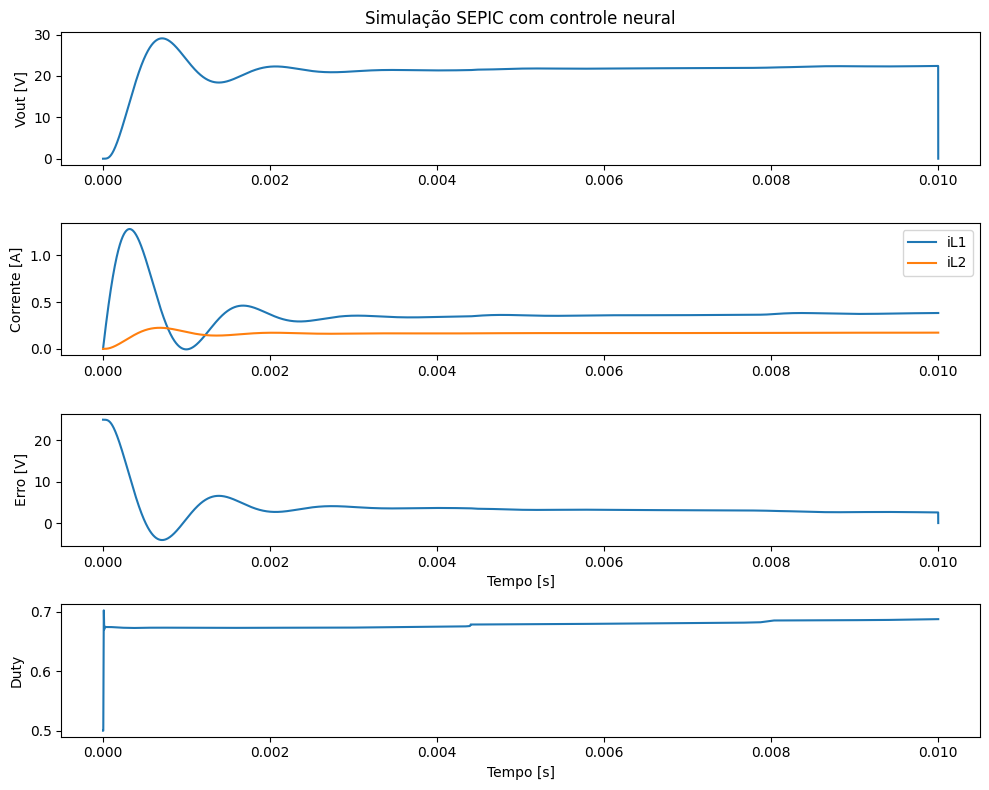

In [176]:
import numpy as np
import matplotlib.pyplot as plt

# ========================================
# 1) Parâmetros do SEPIC
# ========================================
RL1 = 3
RL2 = 8
L1 = 1.56e-3
L2 = 4e-3
C1 = 3.18e-6
Co = 200e-9
R = 129.6
Vin = 12.0

# Duty fixo (você pode trocar depois para variar com o tempo)
Duty = 0.5

# ========================================
# 2) Funções do modelo médio
# ========================================
def build_A(D):
    return np.array([
        [-(RL1 / L1),        0,              -(1 - D) / L1,   0],
        [0,                 -(RL2 / L2),      D / L2,         -1 / L2],
        [(1 - D) / C1,       -D / C1,         0,               0],
        [0,                  1 / Co,          0,              -1 / (R * Co)]
    ])

B = np.array([
    [1 / L1],
    [0],
    [0],
    [0]
])

C = np.array([
    [0, 0, 0, 1],   # Vout
    [1, 0, 0, 0]    # Corrente em L1
])
D_sys = np.zeros((2, 1))

# ========================================
# 3) Função de integração RK4
# ========================================
def rk4_step(f, x, u, dt):
    k1 = f(x, u)
    k2 = f(x + dt/2 * k1, u)
    k3 = f(x + dt/2 * k2, u)
    k4 = f(x + dt * k3, u)
    return x + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

# ========================================
# 4) Simulação temporal
# ========================================
def simulate_sepic_open_loop(Vin, t_final=0.01, dt=50e-6):
    D = 0.5
    A = build_A(D)
    N = int(t_final / dt)
    t = np.linspace(0, t_final, N+1)
    
    
    # Estados: [iL1, iL2, vC1, vCo]
    x = np.zeros((N+1, 4))
    y = np.zeros((N+1, 2))
    error = np.zeros(N+1)
    duty_vector = np.zeros(N+1)
    duty_vector[:5] = 0.5  # inicializa com duty fixo

    x0 = np.zeros(4)
    x[0] = x0
    integral_error =0
    Vref = 25  # apenas para calcular erro
    u = Vin

    A = build_A(duty_vector[1])


    for i in range(1, N+1):
        # Calcular erro atual
        y[i-1] = C @ x[i-1] + D_sys.flatten() * u
        error[i-1] = Vref - y[i-1, 0]
        integral_error += error[i-1] * dt
        integral_error = np.clip(integral_error, -17, 17)

        # Calcular novo duty (a partir do passo anterior)
        if i >= 4:
            e_k = error[i-1]
            e_prev = error[i-2]
            e_prev2 = error[i-3]
            e_prev3 = error[i-4]
            d_prev = duty_vector[i-1]
            d_prev2 = duty_vector[i-2]
            d_prev3 = duty_vector[i-3]
            int_e = integral_error

            features = np.array([e_k, e_prev, e_prev2, e_prev3,
                                d_prev, d_prev2, d_prev3, int_e])
            d_k = predict_duty_tflite(features, scaler)
            d_k = np.clip(d_k, 0.3, 0.9)
        else:
            d_k = duty_vector[i-1]  # mantém inicial

        duty_vector[i] = d_k

        # Atualiza a matriz A com o duty escolhido AGORA
        A = build_A(d_k)

        # Integra o sistema com o duty atual
        def f(x_, u_):
            return A @ x_ + B.flatten() * u_

        x[i] = rk4_step(f, x[i-1], u, dt)



        '''
        e_k = erro[k]
    e_prev = erro[k-1]
    e_prev2 = erro[k-2]
    e_prev3 = erro[k-3]
    d_prev = duty_pred_tflite[-1]
    d_prev2 = duty_pred_tflite[-2]
    d_prev3 = duty_pred_tflite[-3]

        Dutyprev3 = Dutyprev2
        Dutyprev2 = Dutyprev1
        Dutyprev1 = D
        error_ = error[i]
        error_prev1 = error[i-1]
        error_prev2 = error[i-2]
        error_prev3 = error[i-3]
        '''
    return t, x, y, error, duty_vector

# ========================================
# 5) Executar simulação
# ========================================


t, x, y, error, duty_vector = simulate_sepic_open_loop(Vin=12.0, t_final=0.01, dt=1e-6)





# ========================================
# 6) Plotar resultados
# ========================================
plt.figure(figsize=(10,8))

plt.subplot(4,1,1)
plt.plot(t, y[:,0])
plt.ylabel("Vout [V]")
plt.title("Simulação SEPIC com controle neural")

plt.subplot(4,1,2)
plt.plot(t, x[:,0], label='iL1')
plt.plot(t, x[:,1], label='iL2')
plt.ylabel("Corrente [A]")
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, error)
plt.ylabel("Erro [V]")
plt.xlabel("Tempo [s]")

plt.subplot(4,1,4)
plt.plot(t, duty_vector)
plt.ylabel("Duty")
plt.xlabel("Tempo [s]")

plt.tight_layout()
plt.show()


# RETREINO

In [141]:
import numpy as np
import random
import pandas as pd
from scipy.optimize import minimize

# ---------- Funções auxiliares ----------
#Gera um numero aleatorio entre a e b
def gerar_valor_aleatorio(a, b):
    return random.uniform(a, b)

#Gera uma função que retorna valores em degraus, mudando nos tempos definidos.
def gerar_funcao_variavel(tempos, valores, valor_padrao):
    def func(i, N):
        t = i / N
        for k in range(len(tempos)):
            if t < tempos[k]:
                return valores[k-1] if k > 0 else valor_padrao
        return valores[-1]
    return func

def gerar_variaveis_aleatorias():
    qtd_var_Vin = random.randint(1, 4)  # até 4 mudanças de Vin
    qtd_var_Vref = random.randint(1, 3) # até 3 mudanças de Vref

    
    tempos_Vin = sorted([gerar_valor_aleatorio(0, 1) for _ in range(qtd_var_Vin)])
    valores_Vin = [gerar_valor_aleatorio(12, 20) for _ in range(qtd_var_Vin)]

    tempos_Vref = sorted([gerar_valor_aleatorio(0, 1) for _ in range(qtd_var_Vref)])
    valores_Vref = [gerar_valor_aleatorio(20, 40) for _ in range(qtd_var_Vref)]

    return tempos_Vin, valores_Vin, tempos_Vref, valores_Vref

# ---------- Sua simulação MPC ----------
#Método Runge-Kutta de 4º ordem
def rk4_step(f, x, u, dt):
    k1 = f(x, u)
    k2 = f(x + dt/2 * k1, u)
    k3 = f(x + dt/2 * k2, u)
    k4 = f(x + dt * k3, u)
    return x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

def simulate_rk4_ch2(build_A, B, C, D, u_array, x0, dt, t_final, Vref_array, prediction_steps):
    N = int(t_final / dt)
    t = np.linspace(0, t_final, N + 1)

    x = np.zeros((N + 1, len(x0)))
    y = np.zeros((N + 1, C.shape[0]))
    error_abs = np.zeros(N + 1)
    D_array = np.zeros(N + 1) #Este salva o duty que a rede previu 
    D_array2  = np.zeros(N + 1) #Este salva o duty que seria ideal
    lambda_penalty = 4*150.0
    x[0] = x0
    D_array[:5] = 0.5

    integral_error =0
    for i in range(1, N + 1):

        Vref = Vref_array[i]
        x_prev = x[i-1]
        u = u_array[i]
        prev_Duty = D_array[i-1]

        #Função custo, o MPC busca minimizar ela
        def cost_fn_multi(Dvec):
            D0, D1, D2, D3 = Dvec
            D0, D1, D2, D3 = [np.clip(d, 0.3, 0.9) for d in [D0, D1, D2, D3]]

            D_seq = [D0, D1, D2, D3] + [D3] * (prediction_steps - 4)
            x_temp = x_prev.copy()
            error_sum = 0
            for step in range(prediction_steps):
                A = build_A(D_seq[step])
                def f(x_, u_): return A @ x_ + B.flatten() * u_
                x_temp = rk4_step(f, x_temp, u, dt)
                y_pred = C @ x_temp + D.flatten() * u
                error_sum += (abs(y_pred[0] - Vref) / Vref)**2 #Cálculo do erro

            #Penalidade por variação no duty cycle
            penalty = lambda_penalty * (
                (D0 - prev_Duty)**2 +
                (D1 - D0)**2 +
                (D2 - D1)**2 +
                (D3 - D2)**2
            )
            return error_sum + penalty

        res = minimize(cost_fn_multi,
                       x0=[prev_Duty, prev_Duty, prev_Duty, prev_Duty],
                       bounds=[(0.3, 0.9)]*4,
                       method='L-BFGS-B')
        
        best_D0 = res.x[0]


        if i >= 4:
            e_k = error_abs[i]
            e_prev = error_abs[i-1]
            e_prev2 = error_abs[i-2]
            e_prev3 = error_abs[i-3]
            d_prev = D_array[i-1]
            d_prev2 = D_array[i-2]
            d_prev3 = D_array[i-3]
            int_e = integral_error

            features = np.array([e_k, e_prev, e_prev2, e_prev3,
                                 d_prev, d_prev2, d_prev3, int_e],
                                dtype=float)
            
            d_k = predict_duty_tflite(features, scaler)

            D_array[i] = d_k
            D_array[i] = np.clip(d_k, 0.3, 0.9)


        A_best = build_A(D_array[i])
        def f_best(x_, u_): return A_best @ x_ + B.flatten() * u_
        best_x = rk4_step(f_best, x_prev, u, dt)
        best_y = C @ best_x + D.flatten() * u

        x[i] = best_x
        y[i] = best_y
        error_abs[i] = cost_fn_multi(res.x)
        #D_array[i] = best_D0
        D_array2[i] = best_D0
        integral_error = error_abs[i] * dt + integral_error
        integral_error = np.clip(integral_error, -17, 17)

        





    return t, x, y, error_abs, D_array, D_array2

# ---------- Rodar várias simulações e salvar dataset ----------
def rodar_simulacoes(build_A, B, C, D_sys, num_simulacoes=5, salvar_dataset=True):
    import matplotlib.pyplot as plt

    dt = 50e-6
    t_final = 8e-3
    N = int(t_final / dt) + 1
    t = np.linspace(0, t_final, N)

    dataset = []
    for sim in range(num_simulacoes):
        print(f"\n=== Simulação {sim+1} ===")

        # Gerar variações aleatórias
        tempos_Vin, valores_Vin, tempos_Vref, valores_Vref = gerar_variaveis_aleatorias()

        print("Mudanças de Vin:")
        for tt, vv in zip(tempos_Vin, valores_Vin):
            print(f"t = {tt*t_final*1000:.3f} ms -> Vin = {vv:.2f} V")

        print("Mudanças de Vref:")
        for tt, vv in zip(tempos_Vref, valores_Vref):
            print(f"t = {tt*t_final*1000:.3f} ms -> Vref = {vv:.2f} V")

        # Criar funções
        Vin_func = gerar_funcao_variavel(tempos_Vin, valores_Vin, valores_Vin[0])
        Vref_func = gerar_funcao_variavel(tempos_Vref, valores_Vref, valores_Vref[0])

        # Gerar sinais discretos
        u_array = np.array([Vin_func(i, N) for i in range(N)])
        Vref_array = np.array([Vref_func(i, N) for i in range(N)])

        # Rodar simulação MPC
        x0 = [0, 0, 0, 0]
        t_out, x, y, error_abs, D_array, D_array2 = simulate_rk4_ch2(
            build_A, B, C, D_sys, u_array, x0, dt, t_final, Vref_array, prediction_steps=15
        )

        # Guardar dados no dataset
        linha = np.stack([y[:,0], u_array, Vref_array, D_array, D_array2], axis=1)  # [Vout, Vin, Vref, Duty]
        dataset.append(linha)


        t_ms = t_out * 1000
        '''
        plt.figure(figsize=(12, 8))

        plt.subplot(4, 1, 1)
        plt.plot(t_ms, u_array, label="Vin")
        plt.ylabel("Vin [V]")
        plt.grid(True)

        plt.subplot(4, 1, 2)
        plt.plot(t_ms, Vref_array, 'r--', label="Vref")
        plt.ylabel("Vref [V]")
        plt.grid(True)

        plt.subplot(4, 1, 3)
        plt.plot(t_ms, D_array, label="Duty")
        plt.ylabel("Duty")
        plt.grid(True)

        plt.subplot(4, 1, 4)
        plt.plot(t_ms, y[:,0], label="Vout")
        plt.plot(t_ms, Vref_array, 'r--', alpha=0.7, label="Vref")
        plt.ylabel("Vout [V]")
        plt.xlabel("Tempo [ms]")
        plt.legend()
        plt.grid(True)

        plt.suptitle(f"Simulação {sim+1}")
        plt.tight_layout()
        plt.show()
'''

    dataset = np.array(dataset)

    if salvar_dataset:
        import pandas as pd
        n = dataset.shape[1]
        colunas = ['Vout', 'Vin', 'Vref', 'Duty_pred', 'Duty_opt']
        colunas_expand = [f"{c}_{i}" for i in range(n) for c in colunas]
        df = pd.DataFrame(dataset.reshape(num_simulacoes, -1), columns=colunas_expand)
        df.to_csv("dataset_mpc.csv_2", index=False)
        print("\nDataset salvo como dataset_mpc.csv_2")

    return dataset


In [142]:
dataset = rodar_simulacoes(build_A, B, C, D_sys, num_simulacoes=1000, salvar_dataset=True)


=== Simulação 1 ===
Mudanças de Vin:
t = 1.483 ms -> Vin = 18.54 V
Mudanças de Vref:
t = 0.001 ms -> Vref = 39.97 V
t = 6.767 ms -> Vref = 21.52 V

=== Simulação 2 ===
Mudanças de Vin:
t = 2.350 ms -> Vin = 16.88 V
t = 4.314 ms -> Vin = 13.06 V
t = 5.525 ms -> Vin = 17.30 V
t = 6.131 ms -> Vin = 19.56 V
Mudanças de Vref:
t = 4.420 ms -> Vref = 28.31 V
t = 5.585 ms -> Vref = 33.53 V
t = 6.288 ms -> Vref = 25.63 V

=== Simulação 3 ===
Mudanças de Vin:
t = 1.823 ms -> Vin = 15.18 V
t = 1.826 ms -> Vin = 14.19 V
t = 6.962 ms -> Vin = 13.43 V
t = 7.938 ms -> Vin = 14.53 V
Mudanças de Vref:
t = 5.566 ms -> Vref = 20.02 V
t = 6.226 ms -> Vref = 29.57 V

=== Simulação 4 ===
Mudanças de Vin:
t = 4.300 ms -> Vin = 19.17 V
Mudanças de Vref:
t = 1.714 ms -> Vref = 34.49 V

=== Simulação 5 ===
Mudanças de Vin:
t = 0.344 ms -> Vin = 12.62 V
t = 1.250 ms -> Vin = 16.91 V
t = 1.255 ms -> Vin = 18.08 V
t = 4.878 ms -> Vin = 19.46 V
Mudanças de Vref:
t = 2.383 ms -> Vref = 33.56 V

=== Simulação 6 ===


KeyboardInterrupt: 

In [147]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# =========================
# 1) Carregar e unir datasets
# =========================
df_old = pd.read_csv("dataset_mpc.csv")
df_new = pd.read_csv("dataset_mpc.csv_2")

# Cada dataset pode ter número diferente de colunas, vamos verificar
print("Shape dataset antigo:", df_old.shape)
print("Shape dataset novo:", df_new.shape)

# O dataset novo tem [Vout, Vin, Vref, Duty, Duty_ideal]
# Vamos descobrir o número de pontos:
# Calcular número de pontos com base em colunas "Vout"
n_points_old = len([c for c in df_old.columns if "Vout" in c])
n_points_new = len([c for c in df_new.columns if "Vout" in c])

print("n_points_old:", n_points_old)
print("n_points_new:", n_points_new)
# =========================
# 2) Função auxiliar para montar X e y
# =========================
def montar_X_y(df, n_points, usar_duty_ideal=False):
    X_list, y_list = [], []
    dt = 50e-6  # passo de tempo
    num_sim = len(df)

    for sim in range(num_sim):
        Vout = df.iloc[sim].filter(like="Vout").values
        Vin = df.iloc[sim].filter(like="Vin").values
        Vref = df.iloc[sim].filter(like="Vref").values

        # Seleciona o tipo de duty dependendo do dataset
        if usar_duty_ideal:
            Duty = df.iloc[sim].filter(like="Duty_opt_").values  # duty ótimo (novo dataset)
        else:
            Duty = df.iloc[sim].filter(like="Duty_").values      # duty normal (dataset antigo)

        erro = Vref - Vout
        integral_erro = np.cumsum(erro) * dt
        integral_erro = np.clip(integral_erro, -17, 17)

        for k in range(4, n_points):
            e_k = erro[k]
            e_prev = erro[k-1]
            e_prev2 = erro[k-2]
            e_prev3 = erro[k-3]
            d_prev = Duty[k-1]
            d_prev2 = Duty[k-2]
            d_prev3 = Duty[k-3]
            int_e = integral_erro[k]

            X_list.append([e_k, e_prev, e_prev2, e_prev3,
                           d_prev, d_prev2, d_prev3, int_e])
            y_list.append(Duty[k])  # saída desejada

    return np.array(X_list), np.array(y_list)


# =========================
# 3) Gerar dados dos dois datasets
# =========================
X_old, y_old = montar_X_y(df_old, n_points_old, usar_duty_ideal=False)
X_new, y_new = montar_X_y(df_new, n_points_new, usar_duty_ideal=True)

# Combinar os datasets
X = np.vstack((X_old, X_new))
y = np.concatenate((y_old, y_new))

print("Dataset combinado:", X.shape, y.shape)

# =========================
# 4) Pré-processamento
# =========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalizar saída duty (0.3 a 0.9)
y_scaled = (y - 0.3) / (0.9 - 0.3)

# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled,
                                                    test_size=0.2, shuffle=True)

# =========================
# 5) Definir e treinar MLP
# =========================
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(8,)),   # 8 entradas
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse',
              metrics=['mae'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=6,
                    batch_size=128,
                    verbose=1)

# =========================
# 6) Avaliar desempenho
# =========================
loss, mae = model.evaluate(X_test, y_test)
print(f"\nLoss={loss:.6f}, MAE={mae:.6f}")

# Converter saída de volta para duty real
def predict_duty(features):
    f_scaled = scaler.transform([features])
    d_norm = model.predict(f_scaled)[0,0]
    duty = d_norm * (0.9 - 0.3) + 0.3
    return duty

# =========================
# 7) Exportar para TFLite
# =========================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("mpc_mlp_v2.tflite", "wb") as f:
    f.write(tflite_model)

print("\n✅ Novo modelo salvo como mpc_mlp_v2.tflite")


Shape dataset antigo: (10000, 644)
Shape dataset novo: (1000, 805)
n_points_old: 161
n_points_new: 161
Dataset combinado: (1727000, 8) (1727000,)
Epoch 1/6
10794/10794 ━━━━━━━━━━━━━━━━━━━━ 6s 492us/step - loss: 5.5213e-04 - mae: 0.0132 - val_loss: 5.1549e-04 - val_mae: 0.0166
Epoch 2/6
10794/10794 ━━━━━━━━━━━━━━━━━━━━ 5s 497us/step - loss: 4.6649e-05 - mae: 0.0047 - val_loss: 4.8038e-04 - val_mae: 0.0161
Epoch 3/6
10794/10794 ━━━━━━━━━━━━━━━━━━━━ 5s 488us/step - loss: 3.6430e-05 - mae: 0.0041 - val_loss: 4.4261e-04 - val_mae: 0.0156
Epoch 4/6
10794/10794 ━━━━━━━━━━━━━━━━━━━━ 5s 489us/step - loss: 3.1396e-05 - mae: 0.0038 - val_loss: 5.6570e-04 - val_mae: 0.0172
Epoch 5/6
10794/10794 ━━━━━━━━━━━━━━━━━━━━ 5s 475us/step - loss: 2.8676e-05 - mae: 0.0036 - val_loss: 8.1338e-04 - val_mae: 0.0203
Epoch 6/6
10794/10794 ━━━━━━━━━━━━━━━━━━━━ 5s 480us/step - loss: 2.7106e-05 - mae: 0.0034 - val_loss: 7.9687e-04 - val_mae: 0.0201
10794/10794 ━━━━━━━━━━━━━━━━━━━━ 3s 283us/step - loss: 7.9795e-04 - 

INFO:tensorflow:Assets written to: C:\Users\YGORDE~1\AppData\Local\Temp\tmp2slrj89t\assets


Saved artifact at 'C:\Users\YGORDE~1\AppData\Local\Temp\tmp2slrj89t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8), dtype=tf.float32, name='keras_tensor_70')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2546866437136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2546866427984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2546866437312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2546866422528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2546866421824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2546866426400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2546866427104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2544753540464: TensorSpec(shape=(), dtype=tf.resource, name=None)

✅ Novo modelo salvo como mpc_mlp_v2.tflite


In [ ]:
print([c for c in df_new.columns if "Duty" in c][:20])


['Duty_pred_0', 'Duty_opt_0', 'Duty_pred_1', 'Duty_opt_1', 'Duty_pred_2', 'Duty_opt_2', 'Duty_pred_3', 'Duty_opt_3', 'Duty_pred_4', 'Duty_opt_4', 'Duty_pred_5', 'Duty_opt_5', 'Duty_pred_6', 'Duty_opt_6', 'Duty_pred_7', 'Duty_opt_7', 'Duty_pred_8', 'Duty_opt_8', 'Duty_pred_9', 'Duty_opt_9']


In [ ]:
from scipy.optimize import minimize



def rk4_step(f, x, u, dt):
    k1 = f(x, u)
    k2 = f(x + dt/2 * k1, u)
    k3 = f(x + dt/2 * k2, u)
    k4 = f(x + dt * k3, u)
    return x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

def simulate_rk4_ch2(build_A, B, C, D, u_array, x0, dt, t_final, Vref, prediction_steps):
    N = int(t_final / dt)
    t = np.linspace(0, t_final, N + 1)

    x = np.zeros((N + 1, len(x0)))
    y = np.zeros((N + 1, C.shape[0]))
    error_abs = np.zeros(N + 1)
    D_array = np.zeros(N + 1)
    Vref_array = np.zeros(N + 1)

    lambda_penalty = 4*150.0
    x[0] = x0
    D_array[0] = 0.5

    for i in range(1, N + 1):

        # Troca de Vref durante a simulação (exemplo)

        if i > N*0.17 and i < N*0.35 :
          #Vref=30
          Vref = 36

        elif i >= N*0.35 and i<N*0.55:
            #Vref = 24
            Vref = 36

        elif i >= N*0.55:
            #Vref = 30
            Vref = 36


        else:
            #Vref = 20
            Vref = 36

        #Vref_array[i] = Vref

        x_prev = x[i-1]
        u = u_array[i]
        prev_Duty = D_array[i-1]

        Vref_k = Vref  # ou defina sua função Vref(t)

        def cost_fn_multi(Dvec):
            D0, D1, D2, D3 = Dvec

            # limitar para segurança
            D0 = np.clip(D0, 0.3, 0.9)
            D1 = np.clip(D1, 0.3, 0.9)
            D2 = np.clip(D1, 0.3, 0.9)
            D3 = np.clip(D1, 0.3, 0.9)

            D_seq = [D0, D1, D2, D3] + [D3] * (prediction_steps - 4)

            x_temp = x_prev.copy()
            error_sum = 0

            for step in range(prediction_steps):
                Duty_k = D_seq[step]
                A = build_A(Duty_k)
                def f(x_, u_): return A @ x_ + B.flatten() * u_
                x_temp = rk4_step(f, x_temp, u, dt)
                y_pred = C @ x_temp + D.flatten() * u
                error = (abs(y_pred[0] - Vref_k) / Vref_k)**2
                error_sum += error

            penalty = lambda_penalty * (
                (D0 - prev_Duty)**2 +
                (D1 - D0)**2 +
                (D2 - D1)**2 +
                (D3 - D2)**2
            )
            return error_sum + penalty

        res = minimize(cost_fn_multi,
                       x0=[prev_Duty, prev_Duty, prev_Duty, prev_Duty],
                       bounds=[(0.3, 0.9)]*4,
                       method='L-BFGS-B')

        best_D0 = res.x[0]  # usamos só o primeiro

        A_best = build_A(best_D0)
        def f_best(x_, u_): return A_best @ x_ + B.flatten() * u_
        best_x = rk4_step(f_best, x_prev, u, dt)
        best_y = C @ best_x + D.flatten() * u

        x[i] = best_x
        y[i] = best_y
        error_abs[i] = cost_fn_multi(res.x)
        D_array[i] = best_D0

    return t, x, y, error_abs, D_array #, Vref_array


In [ ]:
dt = 50e-6
t_final = 8e-3

N = int(t_final / dt) + 1
t = np.linspace(0, t_final, N)
u_array = np.where(t < 1.154e-3, 12,
                   np.where(t < 4.605e-3, 12, 12))

x0 = [0, 0, 0, 0]  # Estado inicial: [iL1, iL2, vC1, Vo]

#Vin = 15  # Entrada constante
#u_array = np.full(int(t_final / dt)+1, Vin)


t, x, y, error_abs, D_array = simulate_rk4_ch2(build_A, B, C, D_sys, u_array, x0, dt, t_final, Vref, prediction_steps=15) #Usar entre 12 e 17 valores maior causam mais overshoot

#t, x, y, error_abs, D_array, Vref_array = simulate_rk4_ch2(build_A, B, C, D_sys, u_array, x0, dt, t_final, Vref, prediction_steps=15) #Usar entre 12 e 17 valores maior causam mais overshoot


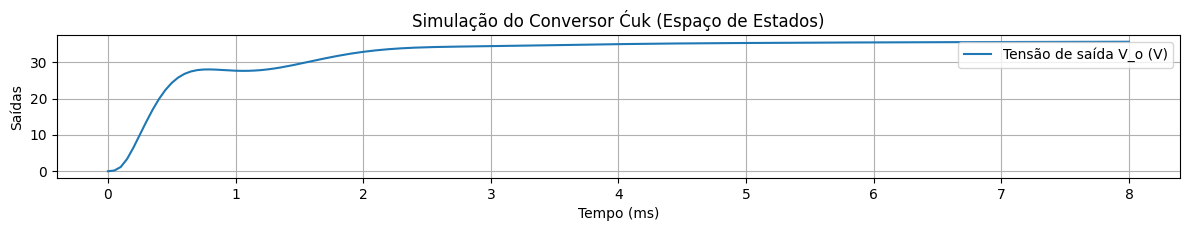

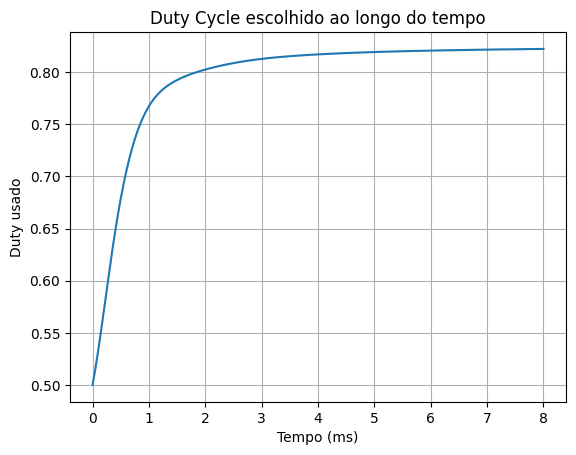

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(t * 1e3, y[:, 0], label='Tensão de saída V_o (V)')
#plt.plot(t * 1e3, Vref_array, '--', label='Vref (V)')
#plt.plot(t * 1e3, y[:, 1], label='Corrente de entrada I_i (A)')
#plt.plot(t * 1e3, D_array*10, label='Duty(D) * 10')
plt.xlabel('Tempo (ms)')
plt.ylabel('Saídas')
plt.title('Simulação do Conversor Ćuk (Espaço de Estados)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(t * 1e3, D_array)
plt.xlabel("Tempo (ms)")
plt.ylabel("Duty usado")
plt.title("Duty Cycle escolhido ao longo do tempo")
plt.grid()
plt.show()